In [ ]:
# calculate EIS for the observations
# for CMIP6 AMIP, EIS is calculated in ~/ClimateFeedbacks/CMIP6/amip/output_EIS.ipynb

In [1]:
import numpy as np
import scipy,math

import numpy as np
import xarray as xr
import pandas as pd
import os

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import *



from scipy import stats
import scipy.io
import pdb, glob,cftime

# import ols
# from xradd import *
# import data
# from data import check

In [2]:
def wv_huss(huss):
    """wv(huss): return water vapor mixing ratio (g/kg)
    using specific humidity"""
    
    return huss/(1-huss)

def wvsat(t,p):
	"""wvsat(t): return water vapor saturation mixing ratio (g/kg)
	over liquid for t > 273 K and over ice for t < 273 K
    t is an xarray DataArray, which includes pressures on coordinate 'level'"""

# 	ind1=np.ma.where(t >= 273.15)
# 	ind2=np.ma.where(t < 273.15)

    # air > freezing
    # Source Hyland, R. W. and A. Wexler, Formulations for the Thermodynamic Properties of the saturated 
    # Phases of H2O from 173.15K to 473.15K, ASHRAE Trans, 89(2A), 500-519, 1983.
	p1 = np.exp(  -0.58002206e4 / t + 0.13914993e1 - 0.48640239e-1 * t 
	+ 0.41764768e-4 * t**2. - 0.14452093e-7 * t**3. 
	+ 0.65459673e1 * np.log(t) ) / 100.

# Source : Goff-Gratch, Smithsonian Meteorological Tables, 5th edition, p. 350, 1984
	ei0	   = 6.1071		  # mbar
	T0	   = 273.16		  # freezing point in K
	p2 = 10.**(-9.09718 * (T0 / t - 1.) - 3.56654 * np.log10(T0 / t) + 0.876793 * (1. - t / T0) + np.log10(ei0))
    
	Psat=t*0
	Psat=Psat.where(t < 273,p2)
	Psat=Psat.where(t > 273,p1)

	return Psat/p*18/29.  # return to kg/kg

def compute_EIS(psfc,Tsfc,RHsfc,t700,full=False):
    """calculate EIS
    from Mark Zelinka
    compute_EIS(psfc,Tsfc,RHsfc,t700)
    
    psfc, RHsfc, Tsfc: pressure (Pa), RH (%) and temperature (K) of the surface
    t700: temperature at 700 hPa"""

    # script modified by MDZ from ncl script provided by Yunyan Zhang

    # psfc # Pa
    # Tsfc # K
    g   = 9.81
    Rd  = 287.04
    Rv  = 461.50
    cpd = 1013.
    Lv  = 2.5e6

    LTS=t700*(700./1000)**(-2./7)-Tsfc*(psfc/100./1000.)**(-2./7)
    
    LTS=LTS.where(psfc>=70000,0.)
    LTS=LTS.where(~np.isnan(LTS),0.)
    LTS=LTS.where(LTS>=0.,0.)
    
    z700 = (Rd*Tsfc/g)*np.log(psfc/70000.)
    zlcl = (20+(Tsfc-273)/5.)*(100-RHsfc)  # meters; hur0 should technically be hurs

    p850 = 850.
    t850 = (Tsfc+t700)/2. # consistent with Wood and Bretherton

    #     qs850 = es_calc(t850-273.15)/(p850*100)*18/29. # temperature (K), pressure (hPa), sat mixing ratio (kg water/kg air)
    qs850 = wvsat(t850,np.array([p850])) # temperature (K), pressure (hPa), sat mixing ratio (kg water/kg air)
    gamma = g/cpd*(1-(1+Lv*qs850/Rd/t850)/(1+Lv**2*qs850/cpd/Rv/t850**2))
    
    EIS = LTS-gamma*(z700-zlcl)
    
    EIS = EIS.where(psfc>=70000,0.)
    EIS = EIS.where(~np.isnan(EIS),0.)
    if full:
        return EIS, LTS
    else:
        return EIS

In [23]:
LAT = np.arange(-88.75,90,2.5)
LON = np.arange(1.25,360,2.5) # lat,lon from kernel

path = '/mnt/data/sn1/lwchao/CERES_ERA5_data/ERA5/'

ps = xr.open_dataset(path+'ERA5_sp.nc')
Td = xr.open_dataset(path+'ERA5_TD2M.nc')
tas = xr.open_dataset(path+'ERA5_T2M_SST_20002021.nc')
ta = xr.open_dataset(path+'ERA5_t_4d_20002021.nc')

data = xr.Dataset()
data = xr.merge([ps.sp.sel(time=slice('2002-07-01','2014-12-30')),
                 Td.d2m.sel(time=slice('2002-07-01','2014-12-30')),
                 tas.t2m.sel(time=slice('2002-07-01','2014-12-30')),
                 ta.t.sel(level=700,time=slice('2002-07-01','2014-12-30'))])

data['time'] = pd.date_range(start='2002-07-01',periods=len(data.time),freq='MS')

data = data.rename({'longitude':'lon','latitude':'lat'})
data = data.drop('level')

# interpolation to 72x144
print('interpolation...')
data = data.interp(lat=LAT,lon=LON,kwargs={"fill_value": "extrapolate"})

print('start calculate EIS')
# RHsfc=wv_huss(data.huss)/wvsat(data.tas,data.ps/100)*100 
RHsfc=wvsat(data.d2m,data.sp/100)/wvsat(data.t2m,data.sp/100)*100 
RHsfc=RHsfc.where(RHsfc<=100.,100.)
EIS=compute_EIS(data.sp,data.t2m,RHsfc,data.t)

EIS.name='EIS'        

print('Saving netcdf file ...')
EIS.to_netcdf('ERA5_EIS_20022014.nc')
print('done')

        

interpolation...
start calculate EIS
Saving netcdf file ...
done


In [25]:
def gavg(idata):
    """calculate global average
    e.g., x1=gavg(d1['t2m'])"""
    
    wgt1=np.cos(np.deg2rad(idata.lat))*(idata*0+1)
    ga=(wgt1*idata).sum(dim=['lat','lon'])/wgt1.sum(dim=['lat','lon'])

    return ga

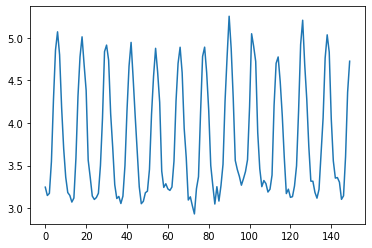

In [26]:
plt.plot(gavg(EIS))

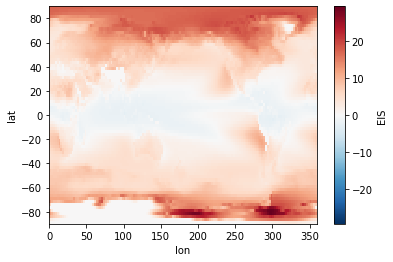

In [27]:
EIS.mean('time').plot()

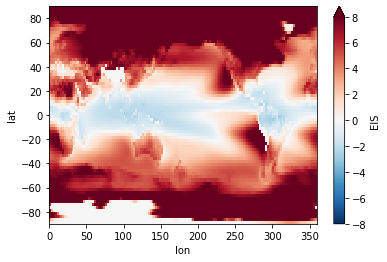

In [28]:
EIS.mean('time').plot(vmin=-8,vmax=8,cmap='RdBu_r')